# Práctica 3
Objetivo: Probar metodos de clasificación no supervisados y supervisados para entrenar y evaluar modelos que sean capaces de clasificar y distinguir entre 3 tipos de cancer cerebral en imagenes ".jpg"
Alumnos: 
- Romero Estrada Daniel


Importanción de librerias.

In [140]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import bone, pcolor, colorbar
import seaborn as sns
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, random_split
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                            confusion_matrix,
                            accuracy_score,
                            )
from xgboost import XGBClassifier
from minisom import MiniSom


Carga el conjunto de datos de imágenes médicas, se le aplican transformaciones y se convierten a tensores y se aplica normalización previa al paso por modelos preentrenados.

In [141]:
# Configuración general
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "Brain_Cancer"
img_size = 128  # En lugar de 224
batch_size = 64
num_classes = 3

In [142]:
# Transformaciones
base_tf = Compose([
    Resize((img_size, img_size)),
    Grayscale(num_output_channels=3),
    ToTensor(),
])

# Cargar dataset completo
dataset = ImageFolder(data_dir, transform=base_tf)
class_names = dataset.classes

# División
n = len(dataset)
n_train = int(0.7 * n)
n_val = int(0.15 * n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Metricas básicas de las imagenes.

In [143]:
# Acumuladores
class_stats = {name: {"count": 0, "mean": 0.0, "std": 0.0} for name in class_names}
total_pixels = 0
sum_means = 0
sum_stds = 0

for img, label in dataset:
    # img: Tensor shape (3, H, W), label: int
    # Calcula solo sobre el primer canal
    img_np = img[0].numpy()  # (H, W)
    mean_val = img_np.mean()
    std_val = img_np.std()
    name = class_names[label]
    
    class_stats[name]["count"] += 1
    class_stats[name]["mean"] += mean_val
    class_stats[name]["std"] += std_val
    
    total_pixels += 1
    sum_means += mean_val
    sum_stds += std_val

# Calcula promedios por clase
for name in class_stats:
    if class_stats[name]["count"] > 0:
        class_stats[name]["mean"] /= class_stats[name]["count"]
        class_stats[name]["std"] /= class_stats[name]["count"]

print("Estadísticas por clase:")
for name in class_stats:
    print(f"{name}: imágenes={class_stats[name]['count']} | media={class_stats[name]['mean']:.3f} | std={class_stats[name]['std']:.3f}")

print(f"\nPromedio global - Media: {sum_means/total_pixels:.3f} | Std: {sum_stds/total_pixels:.3f}")

Estadísticas por clase:
brain_glioma: imágenes=2004 | media=0.115 | std=0.144
brain_menin: imágenes=2004 | media=0.156 | std=0.177
brain_tumor: imágenes=2004 | media=0.191 | std=0.162

Promedio global - Media: 0.154 | Std: 0.161


Distribución de las clases.

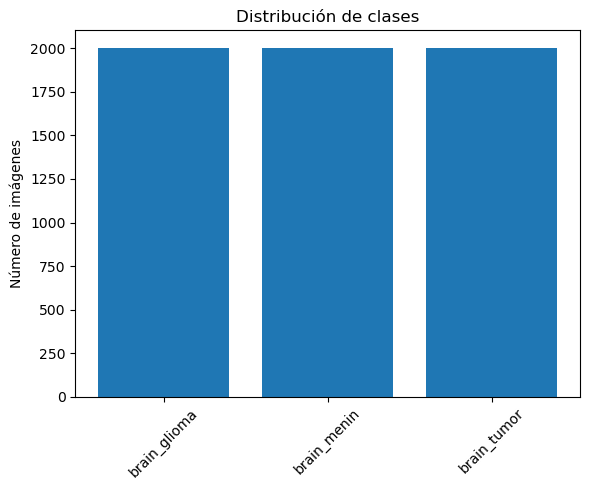

In [144]:
labels = [sample[1] for sample in dataset]
counts = Counter(labels)

plt.figure(figsize=(6, 5))
plt.bar([class_names[i] for i in counts.keys()], counts.values())
plt.title("Distribución de clases")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Distribución con intensidad de las clases, 0 negro - 1 blanco.

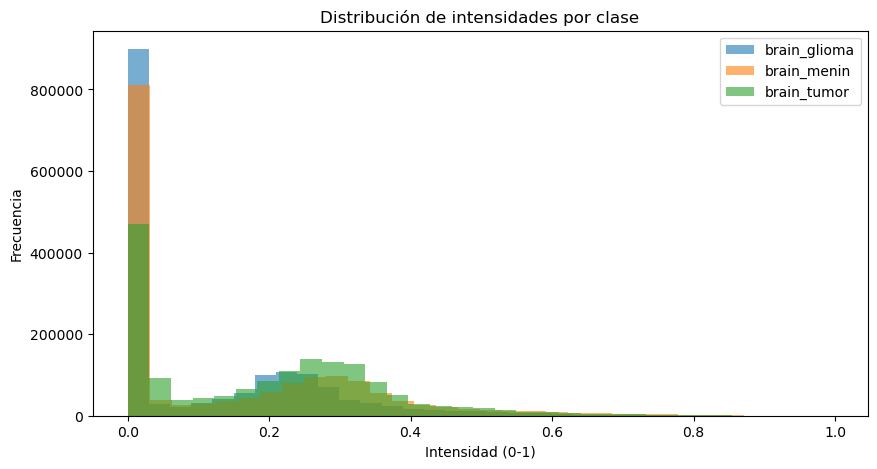

In [145]:
pixels = {name: [] for name in class_names}
n_imgs_per_class = 100

for img, label in dataset:
    name = class_names[label]
    if len(pixels[name]) < n_imgs_per_class:
        # Solo un canal (grises)
        img_np = img[0].numpy().flatten()
        pixels[name].append(img_np)
    if all(len(v) >= n_imgs_per_class for v in pixels.values()):
        break

# Concatenar y graficar
plt.figure(figsize=(10, 5))
for name in class_names:
    vals = np.concatenate(pixels[name])
    plt.hist(vals, bins=32, alpha=0.6, label=name)
plt.title("Distribución de intensidades por clase")
plt.xlabel("Intensidad (0-1)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

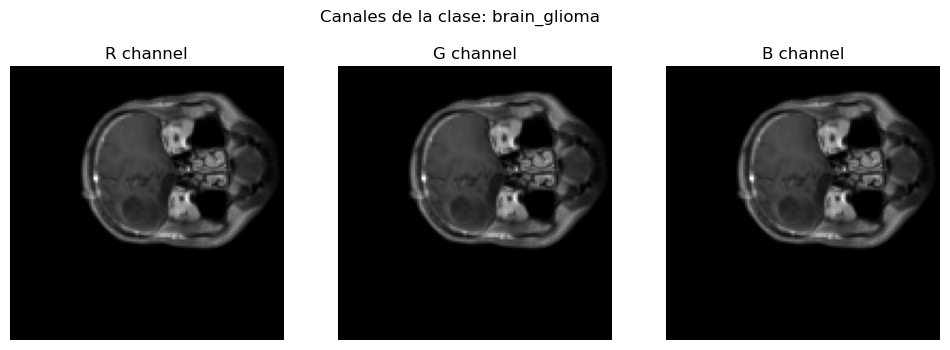

In [146]:
img, label = dataset[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, color in enumerate(['R', 'G', 'B']):
    axs[i].imshow(img[i].numpy(), cmap='gray')
    axs[i].set_title(f"{color} channel")
    axs[i].axis('off')
plt.suptitle(f"Canales de la clase: {class_names[label]}")
plt.show()

Muestro de una imagen por clase.

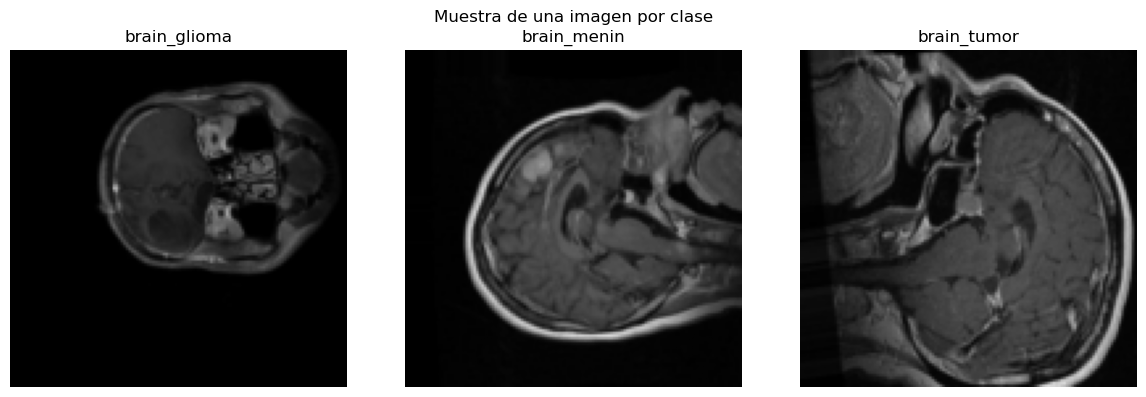

In [147]:
sample_imgs = {}
for img, label in dataset:
    if label not in sample_imgs:
        sample_imgs[label] = img
    if len(sample_imgs) == len(class_names):
        break

fig, axes = plt.subplots(1, len(class_names), figsize=(12, 4))
for i, (label, img) in enumerate(sample_imgs.items()):
    axes[i].imshow(img.permute(1, 2, 0), cmap='gray')
    axes[i].set_title(class_names[label])
    axes[i].axis('off')
plt.suptitle("Muestra de una imagen por clase")
plt.tight_layout()
plt.show()

Uso de DenseNet201 para obtener las caracteristicas de las iamgenes segun el módelo.

In [148]:
# Cargar DenseNet201
model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
model.classifier = nn.Identity()
model = model.to(device)
model.eval()

# Extraer embeddings
features, labels = [], []
with torch.no_grad():
    for X, y in DataLoader(dataset, batch_size=32):
        X = X.to(device)
        out = model.features(X)
        out = nn.functional.relu(out, inplace=True)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1)).view(X.size(0), -1)
        features.append(out.cpu())
        labels.extend(y.numpy())
features = torch.cat(features, dim=0).numpy()
labels = np.array(labels)

Gráfica de inercia para la elección optima de dimenciones para el PCA.

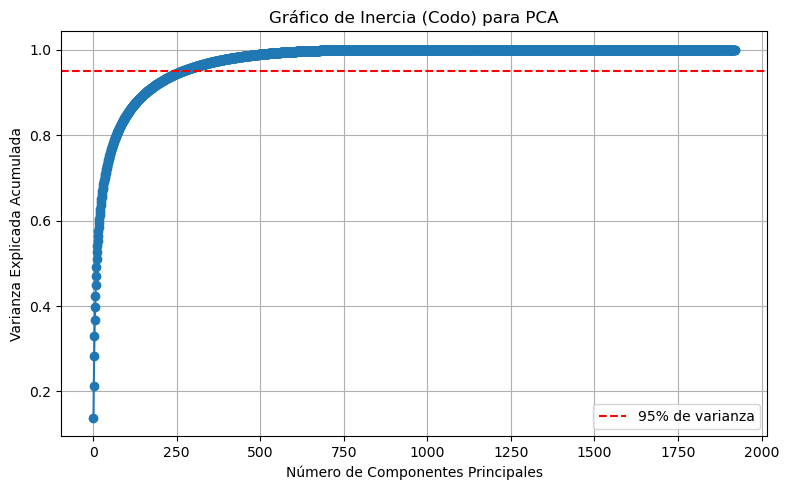

Numero optimo de componentes: 267


In [149]:
# PCA sin reducción previa para graficar todas las componentes
pca_full = PCA()
pca_full.fit(features)

# Varianza explicada acumulada
explained_var_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_var_ratio)+1), explained_var_ratio, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% de varianza")
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Gráfico de Inercia (Codo) para PCA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Numero optimo de componentes:", np.argmax(explained_var_ratio >= 0.95))

Aplicación de t-SNE con la reducción de PCA.

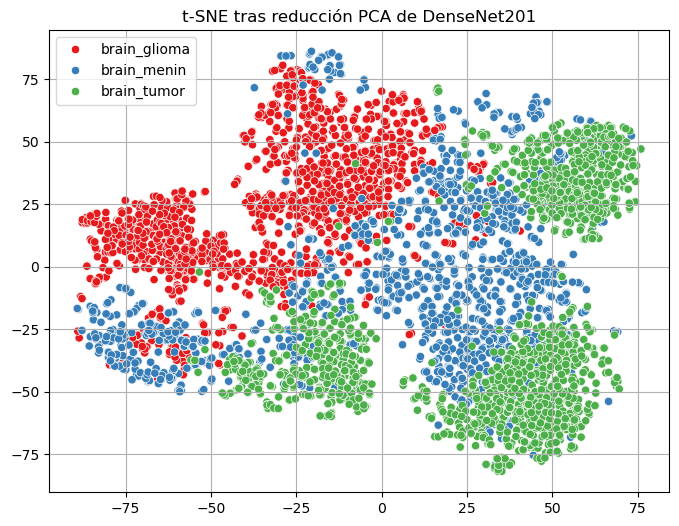

In [150]:
# Reducción de dimensionalidad
pca = PCA(n_components=267).fit_transform(features)
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=[class_names[i] for i in labels], palette="Set1")
plt.title("t-SNE tras reducción PCA de DenseNet201")
plt.grid(True)
plt.show()

Aplicación de SOM.

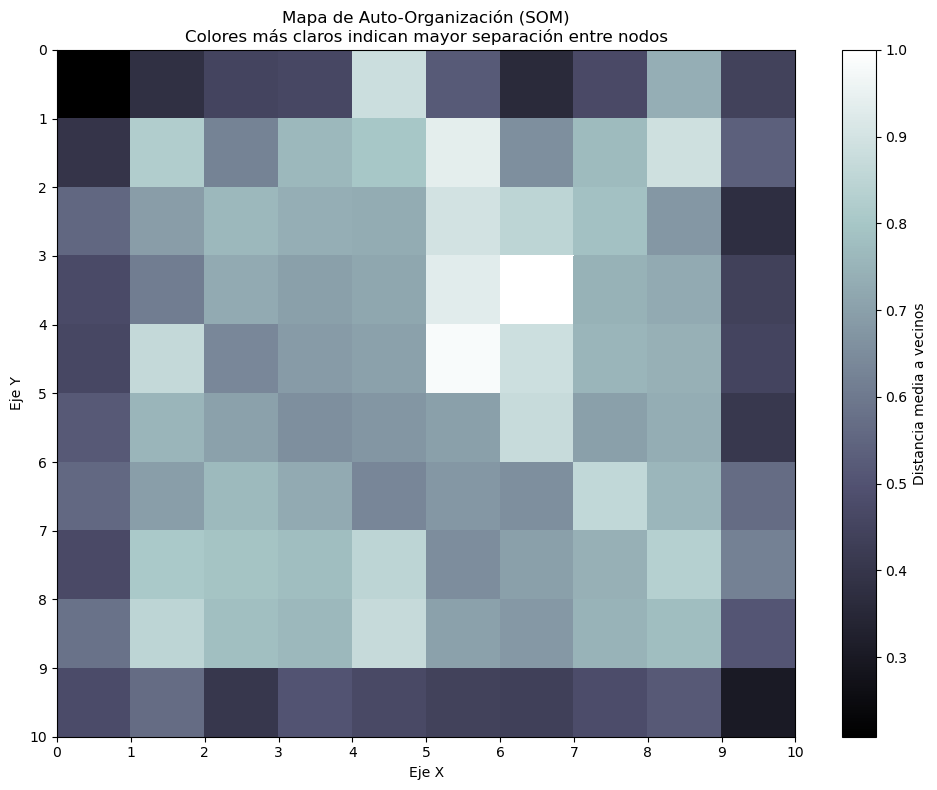

In [151]:
som = MiniSom(x=10, y=10, input_len=features.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(features)
som.train_random(data=features, num_iteration=1000)

# Mapa de distancias (U-Matrix)
u_matrix = som.distance_map().T

# Visualización mejorada del mapa
plt.figure(figsize=(10, 8))
plt.title("Mapa de Auto-Organización (SOM)\nColores más claros indican mayor separación entre nodos")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")

# Gráfico base del SOM (U-Matrix)
bone()
pcolor(u_matrix, cmap='bone')  # puedes probar cmap='coolwarm' o 'viridis' si lo prefieres
colorbar(label='Distancia media a vecinos')

# Estética del eje
plt.xticks(np.arange(0, som.get_weights().shape[0]+1, 1))
plt.yticks(np.arange(0, som.get_weights().shape[1]+1, 1))
plt.gca().invert_yaxis()
plt.grid(False)

plt.tight_layout()
plt.show()

Entrenamiento de clasificadores con la información de DenseNet201.

/opt/conda/envs/brain-tumor-cluster/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


 Logistic Regression - Accuracy: 0.948
              precision    recall  f1-score   support

      Glioma       0.96      0.97      0.96       401
  Meningioma       0.92      0.94      0.93       401
       Tumor       0.96      0.94      0.95       401

    accuracy                           0.95      1203
   macro avg       0.95      0.95      0.95      1203
weighted avg       0.95      0.95      0.95      1203



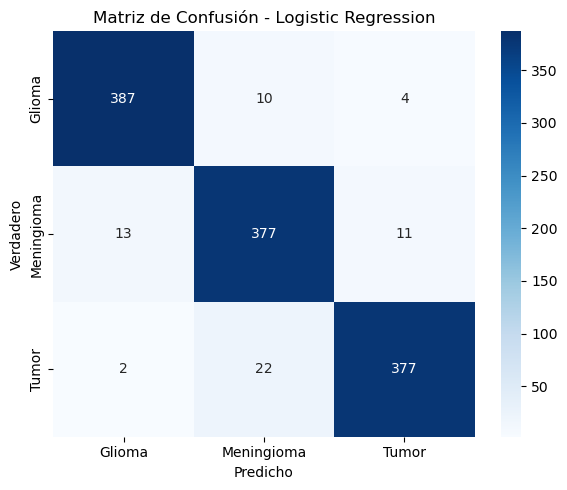

 Random Forest - Accuracy: 0.913
              precision    recall  f1-score   support

      Glioma       0.96      0.92      0.94       401
  Meningioma       0.87      0.89      0.88       401
       Tumor       0.91      0.93      0.92       401

    accuracy                           0.91      1203
   macro avg       0.91      0.91      0.91      1203
weighted avg       0.91      0.91      0.91      1203



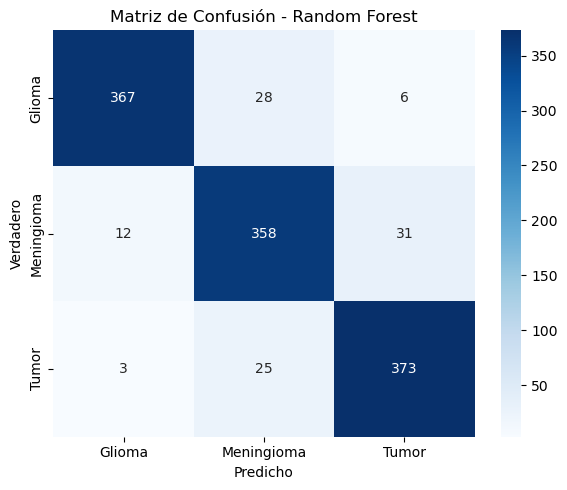

 SVM - Accuracy: 0.938
              precision    recall  f1-score   support

      Glioma       0.98      0.93      0.95       401
  Meningioma       0.89      0.94      0.91       401
       Tumor       0.95      0.95      0.95       401

    accuracy                           0.94      1203
   macro avg       0.94      0.94      0.94      1203
weighted avg       0.94      0.94      0.94      1203



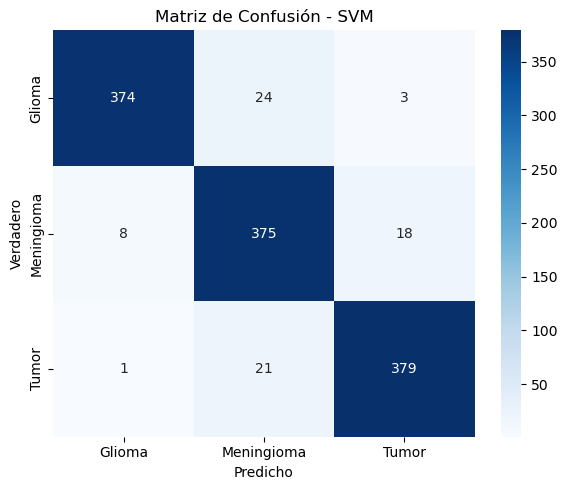

 XGBoost - Accuracy: 0.948
              precision    recall  f1-score   support

      Glioma       0.98      0.96      0.97       401
  Meningioma       0.92      0.94      0.93       401
       Tumor       0.95      0.95      0.95       401

    accuracy                           0.95      1203
   macro avg       0.95      0.95      0.95      1203
weighted avg       0.95      0.95      0.95      1203



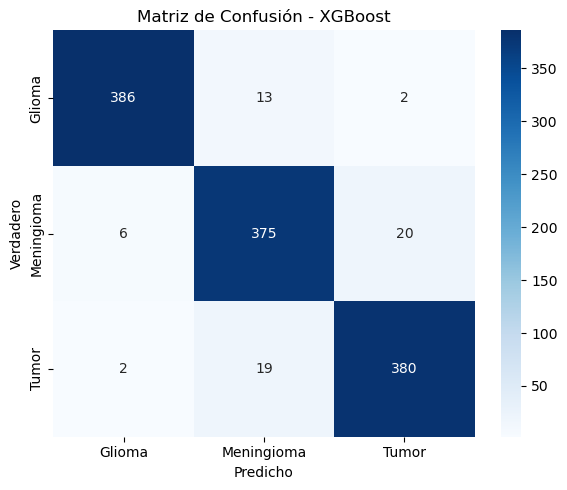

In [152]:
# Clasificadores clásicos
X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

clase_nombres = ['Glioma', 'Meningioma', 'Tumor']
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f" {nombre} - Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=clase_nombres))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clase_nombres, yticklabels=clase_nombres)
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel("Predicho")
    plt.ylabel("Verdadero")
    plt.tight_layout()
    plt.show()

Extración de etiquetas y # de muestras y clases.

In [153]:
labels = [sample[1] for sample in dataset]
Counter(labels)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

criterion = CrossEntropyLoss()

Se vuelve a medir la precisión de los clasificadores pero con un tratamiento a los datos.

/opt/conda/envs/brain-tumor-cluster/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Entrenando modelo: Logistic Regression
Accuracy: 0.963
              precision    recall  f1-score   support

      Glioma       0.98      0.97      0.98       401
  Meningioma       0.93      0.97      0.95       401
       Tumor       0.97      0.95      0.96       401

    accuracy                           0.96      1203
   macro avg       0.96      0.96      0.96      1203
weighted avg       0.96      0.96      0.96      1203



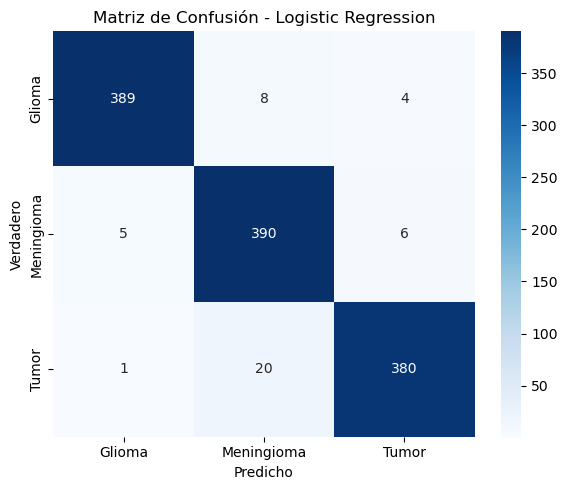


Entrenando modelo: Random Forest
Accuracy: 0.918
              precision    recall  f1-score   support

      Glioma       0.97      0.93      0.95       401
  Meningioma       0.87      0.91      0.89       401
       Tumor       0.91      0.92      0.92       401

    accuracy                           0.92      1203
   macro avg       0.92      0.92      0.92      1203
weighted avg       0.92      0.92      0.92      1203



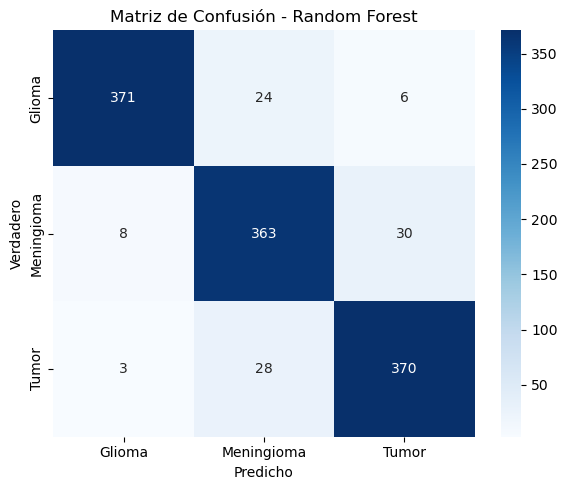


Entrenando modelo: SVM
Accuracy: 0.972
              precision    recall  f1-score   support

      Glioma       0.99      0.98      0.98       401
  Meningioma       0.94      0.98      0.96       401
       Tumor       0.98      0.96      0.97       401

    accuracy                           0.97      1203
   macro avg       0.97      0.97      0.97      1203
weighted avg       0.97      0.97      0.97      1203



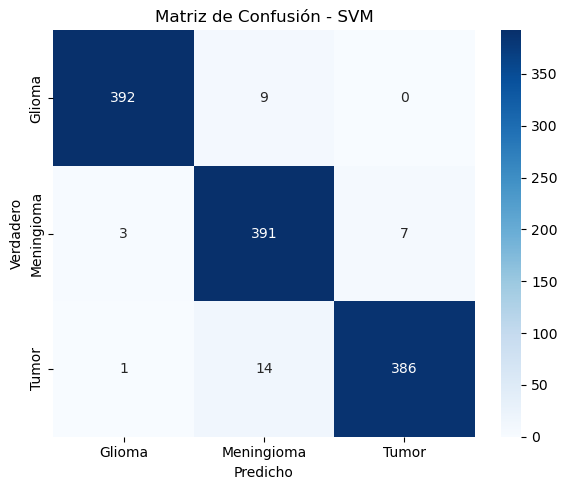


Entrenando modelo: XGBoost
Accuracy: 0.948
              precision    recall  f1-score   support

      Glioma       0.98      0.96      0.97       401
  Meningioma       0.92      0.94      0.93       401
       Tumor       0.95      0.95      0.95       401

    accuracy                           0.95      1203
   macro avg       0.95      0.95      0.95      1203
weighted avg       0.95      0.95      0.95      1203



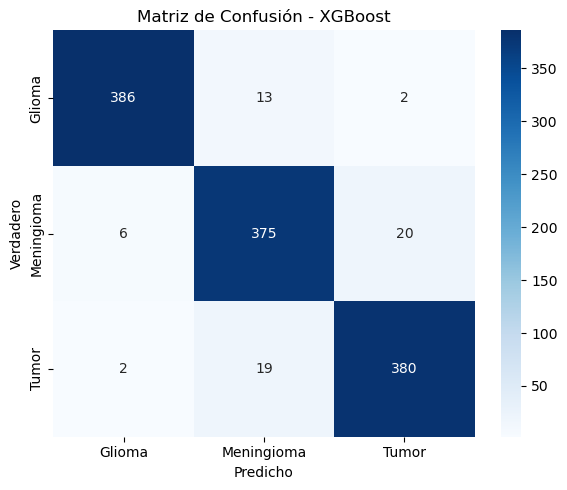

In [154]:
# Usa los datos escalados
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=clase_nombres))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clase_nombres, yticklabels=clase_nombres)
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel("Predicho")
    plt.ylabel("Verdadero")
    plt.tight_layout()
    plt.show()

Modelo pre-entrenado ResNet18.

In [155]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

Modelo pre-entrenado VGG-16.

In [156]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

Modelo pre-entrenado efficientnet_b0.

In [157]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

Modelo pre-entrenado mobilenet_v2.

In [158]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

Función para entrenamiento y evaluación de los modelos.

In [159]:
def train_and_eval(model, name, train_loader, val_loader, epochs=5):
    model = model.to(device)

    weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        total, correct, loss_total = 0, 0, 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            loss_total += loss.item() * y.size(0)
            total += y.size(0)
        acc = correct / total
        print(f"{name} | Epoch {epoch+1} | Train Acc: {acc:.4f} | Loss: {loss_total / total:.4f}")

    # Validación
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            preds = out.argmax(1).cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)

    print(f"\n{name} - Reporte de Clasificación:\n")
    print(classification_report(y_true, y_pred, target_names=dataset.classes))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes,
                yticklabels=dataset.classes)
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicho")
    plt.ylabel("Verdadero")
    plt.show()

Entrenamiento y evaluación de los modelos.

ResNet18 | Epoch 1 | Train Acc: 0.8995 | Loss: 0.2524
ResNet18 | Epoch 2 | Train Acc: 0.9895 | Loss: 0.0405
ResNet18 | Epoch 3 | Train Acc: 0.9962 | Loss: 0.0130
ResNet18 | Epoch 4 | Train Acc: 0.9993 | Loss: 0.0049
ResNet18 | Epoch 5 | Train Acc: 1.0000 | Loss: 0.0020

ResNet18 - Reporte de Clasificación:

              precision    recall  f1-score   support

brain_glioma       0.99      0.98      0.99       278
 brain_menin       0.96      0.99      0.98       317
 brain_tumor       0.99      0.97      0.98       306

    accuracy                           0.98       901
   macro avg       0.98      0.98      0.98       901
weighted avg       0.98      0.98      0.98       901



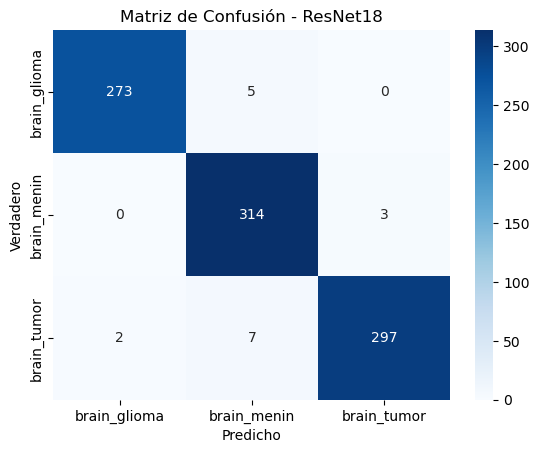

In [160]:
model_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
train_and_eval(model_resnet, "ResNet18", train_loader, val_loader, epochs=5)

VGG16 | Epoch 1 | Train Acc: 0.8750 | Loss: 0.3166
VGG16 | Epoch 2 | Train Acc: 0.9670 | Loss: 0.0899
VGG16 | Epoch 3 | Train Acc: 0.9810 | Loss: 0.0573
VGG16 | Epoch 4 | Train Acc: 0.9867 | Loss: 0.0435
VGG16 | Epoch 5 | Train Acc: 0.9900 | Loss: 0.0278

VGG16 - Reporte de Clasificación:

              precision    recall  f1-score   support

brain_glioma       1.00      0.96      0.98       278
 brain_menin       0.95      0.99      0.97       317
 brain_tumor       0.99      0.98      0.99       306

    accuracy                           0.98       901
   macro avg       0.98      0.98      0.98       901
weighted avg       0.98      0.98      0.98       901



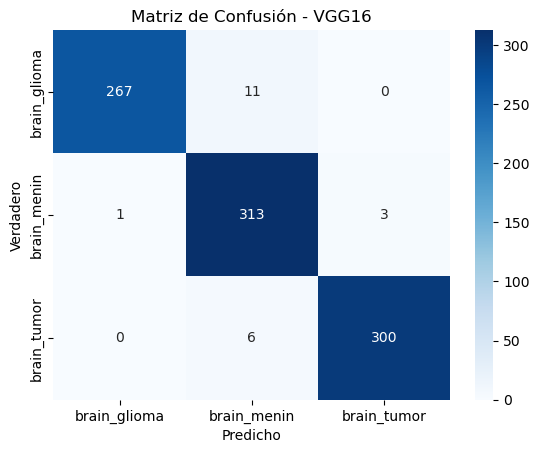

In [161]:
model_vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, num_classes)
train_and_eval(model_vgg, "VGG16", train_loader, val_loader, epochs=5)

EfficientNetB0 | Epoch 1 | Train Acc: 0.8028 | Loss: 0.5538
EfficientNetB0 | Epoch 2 | Train Acc: 0.9472 | Loss: 0.1644
EfficientNetB0 | Epoch 3 | Train Acc: 0.9784 | Loss: 0.0741
EfficientNetB0 | Epoch 4 | Train Acc: 0.9900 | Loss: 0.0395
EfficientNetB0 | Epoch 5 | Train Acc: 0.9943 | Loss: 0.0233

EfficientNetB0 - Reporte de Clasificación:

              precision    recall  f1-score   support

brain_glioma       1.00      0.98      0.99       278
 brain_menin       0.97      0.97      0.97       317
 brain_tumor       0.98      0.99      0.98       306

    accuracy                           0.98       901
   macro avg       0.98      0.98      0.98       901
weighted avg       0.98      0.98      0.98       901



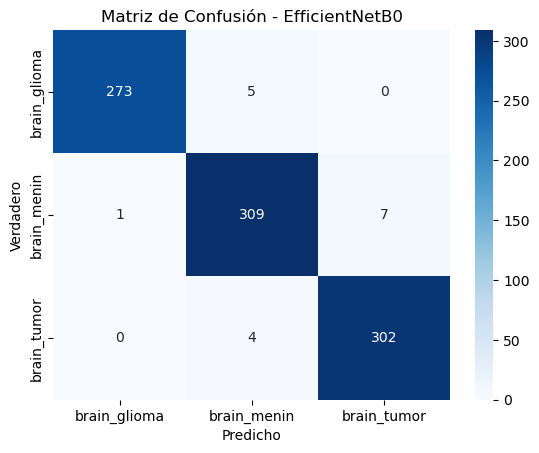

In [162]:
model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, num_classes)
train_and_eval(model_eff, "EfficientNetB0", train_loader, val_loader, epochs=5)

MobileNetV2 | Epoch 1 | Train Acc: 0.8876 | Loss: 0.2820
MobileNetV2 | Epoch 2 | Train Acc: 0.9808 | Loss: 0.0570
MobileNetV2 | Epoch 3 | Train Acc: 0.9981 | Loss: 0.0151
MobileNetV2 | Epoch 4 | Train Acc: 0.9993 | Loss: 0.0064
MobileNetV2 | Epoch 5 | Train Acc: 0.9993 | Loss: 0.0044

MobileNetV2 - Reporte de Clasificación:

              precision    recall  f1-score   support

brain_glioma       0.98      0.98      0.98       278
 brain_menin       0.97      0.94      0.96       317
 brain_tumor       0.95      0.98      0.96       306

    accuracy                           0.97       901
   macro avg       0.97      0.97      0.97       901
weighted avg       0.97      0.97      0.97       901



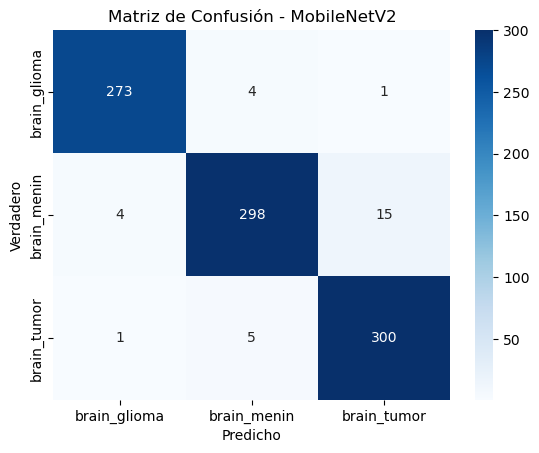

In [163]:
model_mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, num_classes)
train_and_eval(model_mobilenet, "MobileNetV2", train_loader, val_loader, epochs=5)

Se juntan los 3 modelos para realizar una predicción conjunta.

Clasificación - Ensemble
              precision    recall  f1-score   support

brain_glioma       1.00      0.98      0.99       278
 brain_menin       0.97      0.98      0.98       317
 brain_tumor       0.98      0.99      0.99       306

    accuracy                           0.98       901
   macro avg       0.99      0.98      0.98       901
weighted avg       0.98      0.98      0.98       901



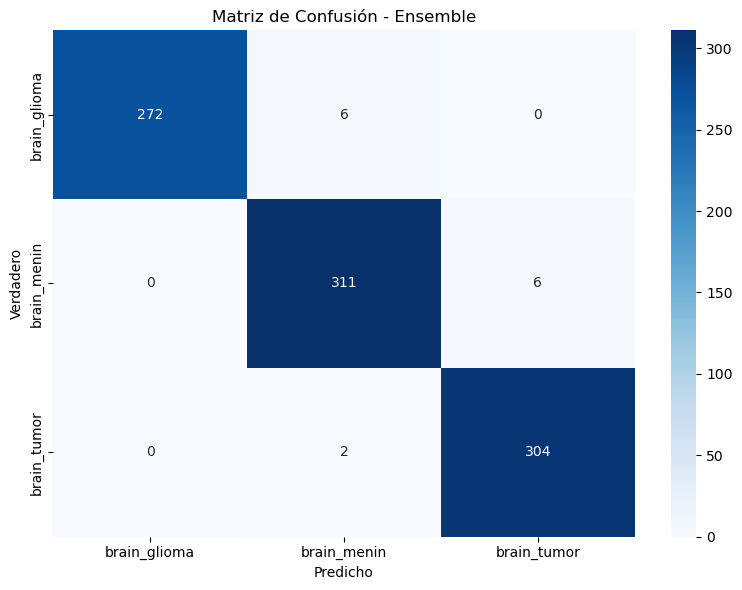

In [164]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

models_ensemble = [model_vgg, model_eff, model_mobilenet]
for m in models_ensemble:
    m.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        logits_sum = None
        for m in models_ensemble:
            out = m(X)
            probs = softmax(out, dim=1)
            logits_sum = probs if logits_sum is None else logits_sum + probs

        avg_probs = logits_sum / len(models_ensemble)
        preds = avg_probs.argmax(1).cpu().numpy()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds)

print("Clasificación - Ensemble")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.title("Matriz de Confusión - Ensemble")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()

Visualización 2D con PCA.

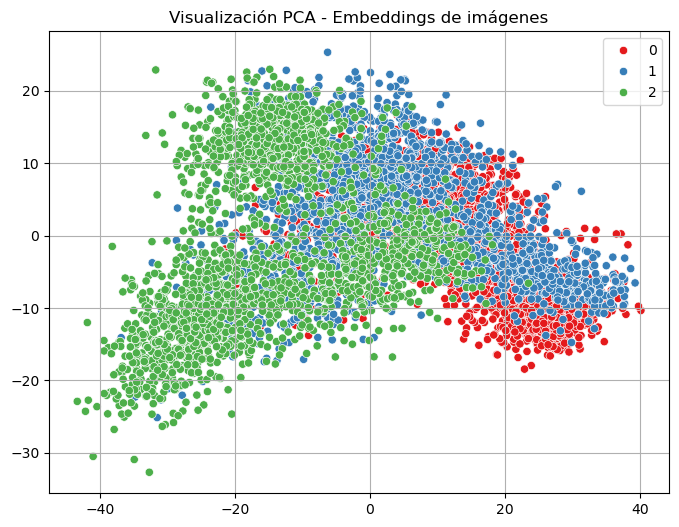

In [165]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(features_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, palette='Set1')
plt.title("Visualización PCA - Embeddings de imágenes")
plt.grid(True)
plt.show()

Visualización 3D con PCA.

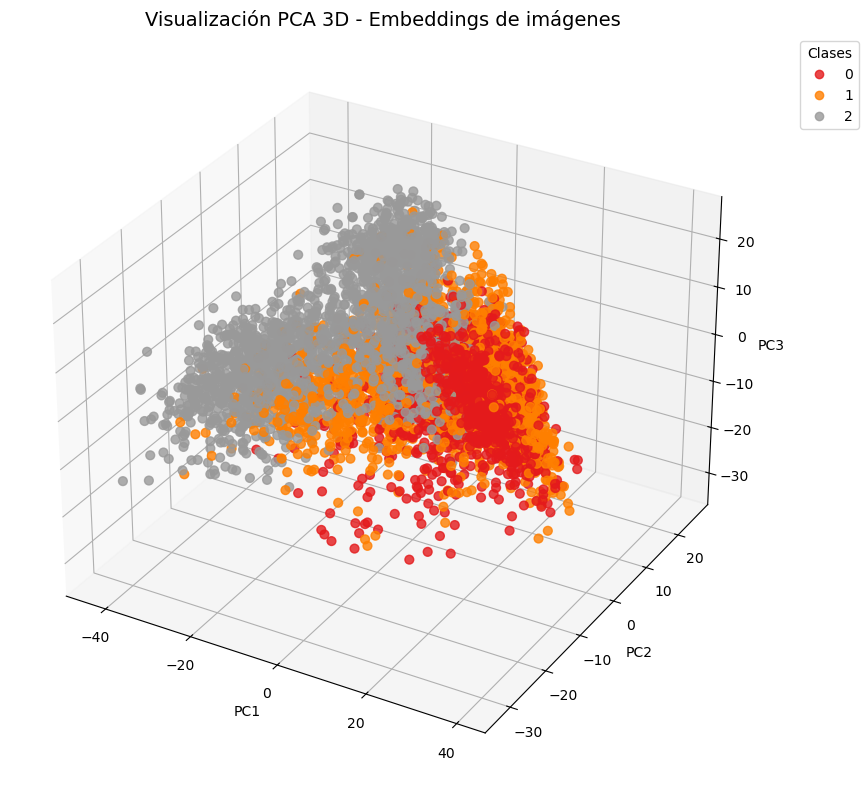

In [166]:
pca = PCA(n_components=3)
reduced = pca.fit_transform(features_scaled)

# Configurar figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Colores por clase
scatter = ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2],
                     c=labels, cmap='Set1', alpha=0.8, s=40)

# Títulos y ejes
ax.set_title("Visualización PCA 3D - Embeddings de imágenes", fontsize=14)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Leyenda
handles, _ = scatter.legend_elements(prop="colors")
legend_labels = np.unique(labels)
ax.legend(handles, legend_labels, title="Clases", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

Se muestran las zonas mas importantes de la imagen para el modelo.

  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:00<00:00, 152.08it/s]


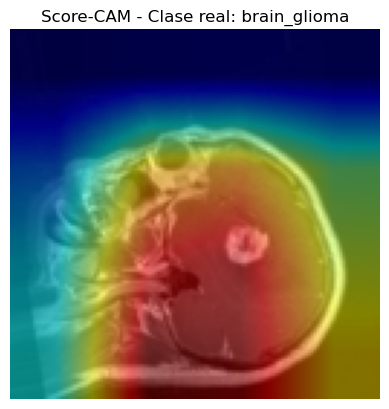

In [167]:
# Selecciona la última capa convolucional de DenseNet201
target_layer = model.features[-1]

# Crear ScoreCAM
cam = ScoreCAM(model=model, target_layers=[target_layer])

# Obtener una imagen del dataset
img_tensor, label = dataset[5]  # Cambia el índice si quieres otra
input_tensor = img_tensor.unsqueeze(0).to(device)

# Aplicar Score-CAM
grayscale_cam = cam(input_tensor=input_tensor)[0]

# Convertir imagen a RGB normalizado
img_np = img_tensor.permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Visualizar el resultado
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Score-CAM - Clase real: {dataset.classes[label]}")
plt.axis('off')
plt.show()

100%|██████████| 80/80 [00:00<00:00, 159.70it/s]


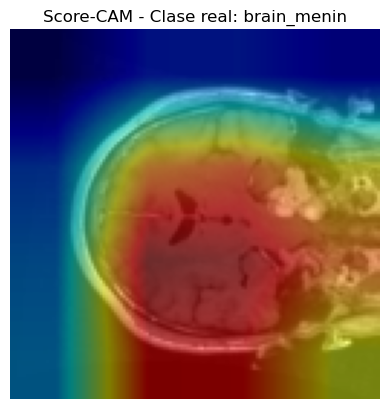

In [168]:
# Selecciona la última capa convolucional de DenseNet201
target_layer = model.features[-1]

# Crear ScoreCAM
cam = ScoreCAM(model=model, target_layers=[target_layer])

# Obtener una imagen del dataset
img_tensor, label = dataset[2589]  # Cambia el índice si quieres otra
input_tensor = img_tensor.unsqueeze(0).to(device)

# Aplicar Score-CAM
grayscale_cam = cam(input_tensor=input_tensor)[0]

# Convertir imagen a RGB normalizado
img_np = img_tensor.permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Visualizar el resultado
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Score-CAM - Clase real: {dataset.classes[label]}")
plt.axis('off')
plt.show()

100%|██████████| 80/80 [00:00<00:00, 159.46it/s]


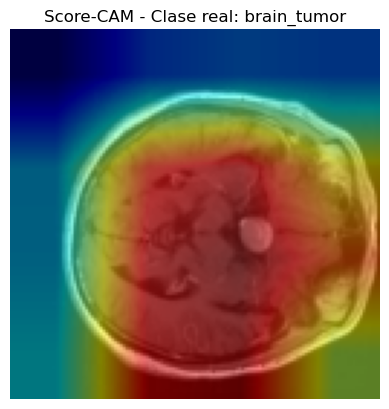

In [169]:
# Selecciona la última capa convolucional de DenseNet201
target_layer = model.features[-1]

# Crear ScoreCAM
cam = ScoreCAM(model=model, target_layers=[target_layer])

# Obtener una imagen del dataset
img_tensor, label = dataset[4589]  # Cambia el índice si quieres otra
input_tensor = img_tensor.unsqueeze(0).to(device)

# Aplicar Score-CAM
grayscale_cam = cam(input_tensor=input_tensor)[0]

# Convertir imagen a RGB normalizado
img_np = img_tensor.permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Visualizar el resultado
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Score-CAM - Clase real: {dataset.classes[label]}")
plt.axis('off')
plt.show()

## Conclusiones

- Romero Estrada Daniel: Respecto a lo aplicado al conjunto de datos, comenzamos a explorer el conjunto con la idea de aplicar modelos de clasificacion, los cuales en un momento se aplicaron esperando obtener un buen resultado, lo cual result ser un problema, dado que no estaban clasificando de forma correcta al conjunto de datos, depsues aplicamos algunos ajustes para meterlos a los modelos y el rendimiento mejoro en un .1 en escala del 0 al 1, lo cual nos hizo cuestionarnos el por que no empleamos redes neuronales, lo cual terminamos empleando 4 modelos de redes neuronales que trabajan con la libreria pythorch, evaluamos, entrenamos y al final del dia los resultados hablaron por si mismos, comenzamos a sacar metricas y ver si las redes neuronales si tomaban las caracteristicas mas relevantes. Al momento de realizar la correccion de el test y train, Podemos llegar a la conclusion de que ambos modelos son correctos, pero al momento de ejecutar los arboles son los mas baratos computacionalmente

